# Import Statements

In [39]:
# Import packages 
import pandas as pd
import numpy as np
import netCDF4
import h5netcdf
import xarray as xr
from os.path import join
import joblib
from glob import glob
import datetime as dt
import sys
import pyresample
import itertools
from pathlib import Path

#Filters
from scipy.ndimage import uniform_filter, maximum_filter, gaussian_filter

#Custom Packages
sys.path.append('/home/samuel.varga/python_packages/WoF_post') #WoF post package
sys.path.append('/home/samuel.varga/python_packages/wofs_ml_severe/')
sys.path.append('/home/samuel.varga/python_packages/MontePython/')
sys.path.append('/home/samuel.varga/projects/deep_learning/')

from wofs.post.utils import (
    save_dataset,
    load_multiple_nc_files,
)
from data_utils.dl_2to6_data_pipeline import get_files, load_dataset
from collections import ChainMap

#Plotting packages
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import shapely
import cartopy
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from wofs.plotting.wofs_colors import WoFSColors
from wofs_ml_severe.data_pipeline.storm_report_loader import StormReportLoader
%matplotlib inline

In [40]:
from data_utils.MRMSutils import MeshGrabber
from data_utils.PatchExtractor import PatchExtractor

# Data Loading

In [41]:
date='20230511_d1' #'20180501','20190523', '20190515', '20200529', '20210510', '20220510' ,'20230530_d1'
init_time='0000'#'0300' #1900

In [42]:
ml_config = { 'ENS_VARS':  ['uh_2to5_instant',
                            'uh_0to2_instant',
                            'wz_0to2_instant',
                            'comp_dz',
                            'ws_80',
                            'hailcast',
                            'w_up',
                            'okubo_weiss',
                            'ctt'
                    ],
             
              'ENV_VARS' : ['mid_level_lapse_rate', 
                            'low_level_lapse_rate', 
                           ],
             
              'SVR_VARS': ['shear_u_0to1', 
                        'shear_v_0to1', 
                        'shear_u_0to6', 
                        'shear_v_0to6',
                        'shear_u_3to6', 
                        'shear_v_3to6',
                        'srh_0to3',
                        'cape_ml', 
                        'cin_ml', 
                        'stp',
                        'scp',
                       ]
            }

In [43]:
data_path=f'/work/mflora/SummaryFiles/{date}/{init_time}'
X_env, X_strm, ncfile, ll_grid  = load_dataset(data_path, TIMESCALE='2to6')

# Plotting Preparation

In [44]:
from wofs.plotting.util import decompose_file_path
dz_levels=np.arange(20,76,5)
cape_levels=np.arange(250,3751,250)
comps = decompose_file_path(ncfile)
start_date=(pd.to_datetime(comps['VALID_DATE']+comps['INIT_TIME'])+dt.timedelta(minutes=int(comps['TIME_INDEX'])*5)) #Beginning of forecast window
end_date=(start_date+dt.timedelta(minutes=240)).strftime('%Y%m%d%H%M') #End of forecast window
start_time=start_date.strftime('%Y%m%d%H%M') 
init_date=(pd.to_datetime(comps['VALID_DATE']+comps['INIT_TIME'])).strftime('%Y%m%d%H%M')

In [45]:
def add_map_stuff(ax, states, shape_feature):
    ax.add_feature(states, linewidth=.1, facecolor='none', edgecolor="black")
    ax.add_feature(cfeature.LAKES, linewidth=.1, facecolor='none', edgecolor="black")
    ax.add_feature(cfeature.COASTLINE, linewidth=.1, facecolor='none', edgecolor="black")        
    ax.add_feature(shape_feature)
    
    
def set_extent(ax, projection , crs, lat, lons,):
    """ Set the Map extent based the WoFS domain """
    # Set the extent. 
    xs, ys, _ = projection.transform_points(
            crs,
            np.array([lons.min(), lons.max()]),
            np.array([lats.min(), lats.max()])).T
    _xlimits = xs.tolist()
    _ylimits = ys.tolist()

    # The limit is max(lower bound), min(upper bound). This will create 
    # a square plot and make sure there is no white spaces between the map
    # the bounding box created by matplotlib. This also allows us to set the
    # WoFS domain boundaries in cases where we aren't plotting WoFS data 
    # (e.g., storm reports, warning polygons, etc.) 
    lims = (max([_xlimits[0]]+[_ylimits[0]]),min([_xlimits[-1]]+[_ylimits[-1]]))
        
    ax.set_xlim(lims)
    ax.set_ylim(lims) 
    
    return ax #0000 is 0000 the next day

In [46]:
ds = xr.load_dataset(ncfile, decode_times=False)
lats = ds['xlat'][::1, ::1]
lons = ds['xlon'][::1, ::1]
base_grid=[lats,lons]
target_grid=[lats[::3, ::3], lons[::3, ::3]]

shape = (len(lons), len(lats))

central_longitude = ds.attrs['STAND_LON']
central_latitude = ds.attrs['CEN_LAT']

standard_parallels = (ds.attrs['TRUELAT1'], ds.attrs['TRUELAT2'])
projection=ccrs.LambertConformal(central_longitude=central_longitude,
                                 central_latitude=central_latitude,
                                 standard_parallels=standard_parallels)
crs = ccrs.PlateCarree()
data_path = '/home/monte.flora/python_packages/WoF_post/wofs/data/'
states = NaturalEarthFeature(category="cultural", scale="10m",
                             facecolor="none",
                             name="admin_1_states_provinces")

county_file = join(data_path,'COUNTIES', 'countyl010g.shp')
reader = shpreader.Reader(county_file)
shape_feature = ShapelyFeature(reader.geometries(),
                               crs, facecolor='none', linewidth=0.2, edgecolor='black', )

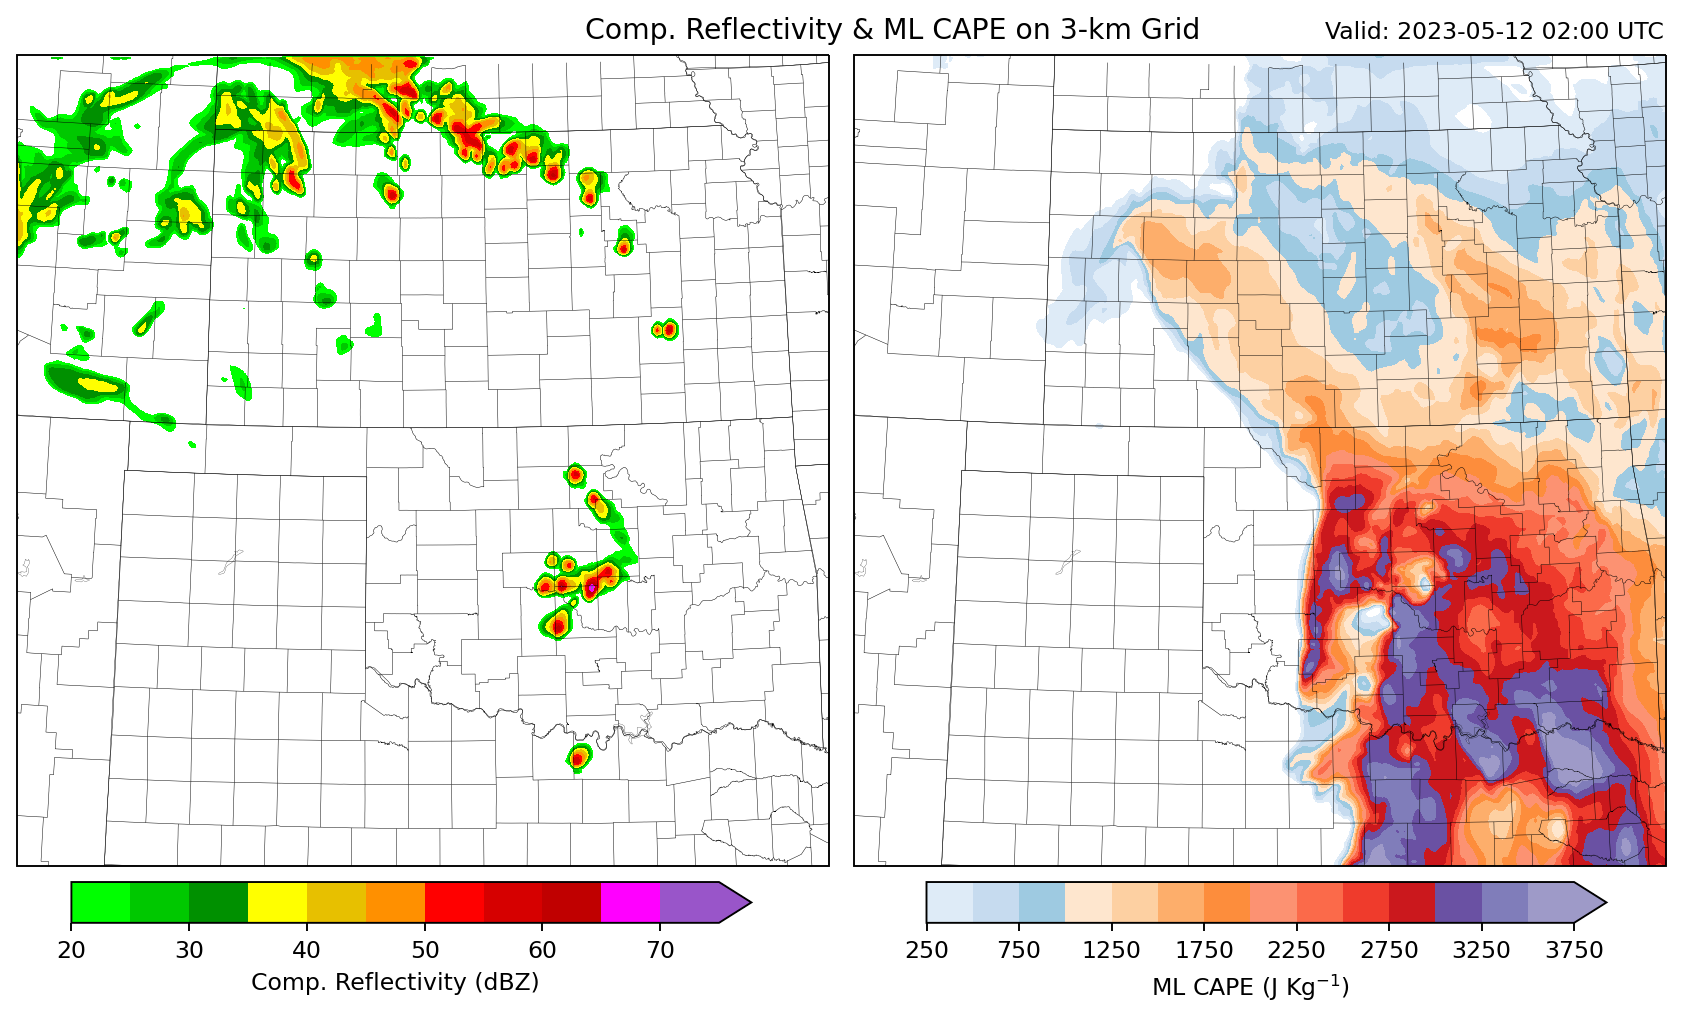

In [47]:
fig, axes = plt.subplots(figsize=(10,8), facecolor='w',
                     dpi=170, nrows=1, ncols=2, subplot_kw={'projection': projection}, 
                        constrained_layout=True)


levels= [dz_levels, cape_levels]
cmaps=[WoFSColors.nws_dz_cmap, WoFSColors.cape_cmap]
labels=['Comp. Reflectivity (dBZ)', 'ML CAPE (J Kg$^{-1}$)']
title='Comp. Reflectivity & ML CAPE on 3-km Grid'
X_s=[X_strm['comp_dz'][0][0],X_env['cape_ml'][0][0]]
conts=[]
for ax, X, name, grid, cmap, level in zip(axes.flat,X_s,labels,[base_grid, base_grid], cmaps, levels):
    add_map_stuff(ax, states, shape_feature)

    cf = ax.contourf(grid[1],grid[0], X, transform = crs, cmap=cmap, levels=level, extend='max')
    conts.append(cf)
    
  
    
    ax = set_extent(ax, projection , crs, grid[0], grid[1],)
    
    fontsize = 10 if len(name) > 5 else 12
    #ax.set_title(f'{name}', fontsize=fontsize)

fig.tight_layout()

cax = [fig.add_axes([0.047, 0.16, 0.4, 0.03]),fig.add_axes([0.55, 0.16, 0.4, 0.03])]
axes[0].annotate(title, (0.7, 1.02), xycoords='axes fraction', fontsize=12, color='k') #(0.7, 1.02)
for cont, ax, label in zip(conts, cax, labels):
      fig.colorbar(cont, cax=ax,label=label, orientation='horizontal', extend='max')
        
#title = f'Valid: {start_time[:4]}-{start_time[4:6]}-{start_time[6:8]} {start_time[8:10]}:{start_time[10:12]} - {end_date[8:10]}:{end_date[10:12]} UTC'        
time_title = f'Valid: {start_time[:4]}-{start_time[4:6]}-{start_time[6:8]} {start_time[8:10]}:{start_time[10:12]} UTC'
axes[1].annotate(time_title, (0.58, 1.02), xycoords='axes fraction', fontsize=10, color='k')
plt.show()

# Patch Extractor

In [48]:
ex=PatchExtractor(ncfile, ll_grid, X_env.keys(), X_strm.keys(), 15, (16,16), verbose=True)
#Build in -1 for dz_t0, MESH missing, raise warning

# Upscale Data and Time Composite

In [49]:
X_strm_upscaled = {v : ex.upscaler(X_strm[v], func=maximum_filter,
                            upscale_size=ex._upscale_size) for v in ex._strm_vars}

In [50]:
X_strm_time_comp=ex.calc_time_composite(X_strm_upscaled, func=np.nanmax, name='time_max', keys=ex._strm_vars)

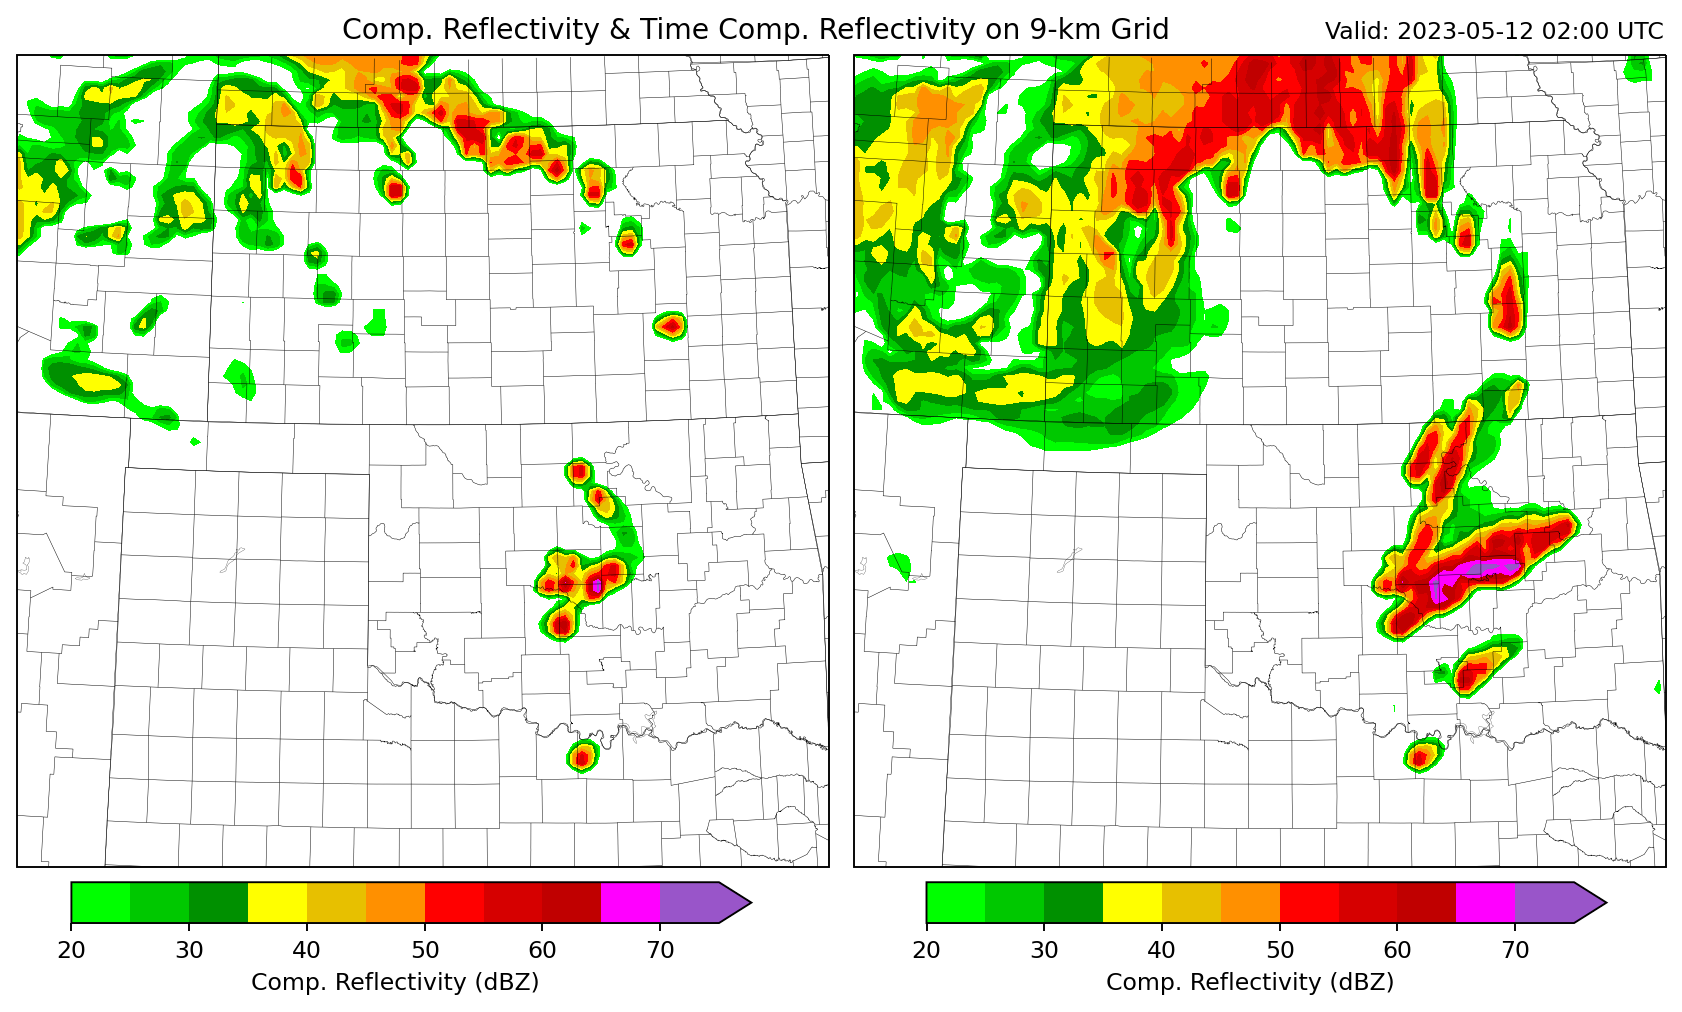

In [51]:
fig, axes = plt.subplots(figsize=(10,8), facecolor='w',
                     dpi=170, nrows=1, ncols=2, subplot_kw={'projection': projection}, 
                        constrained_layout=True)


levels= [dz_levels, dz_levels]
cmaps=[WoFSColors.nws_dz_cmap, WoFSColors.nws_dz_cmap]
labels=['Comp. Reflectivity (dBZ)', 'Comp. Reflectivity (dBZ)']
title='Comp. Reflectivity & Time Comp. Reflectivity on 9-km Grid'
X_s=[X_strm_upscaled['comp_dz'][0][0],X_strm_time_comp['comp_dz__time_max'][0]]

conts=[]
for ax, X, name, grid, cmap, level in zip(axes.flat,X_s,labels,[target_grid, target_grid], cmaps, levels):
    add_map_stuff(ax, states, shape_feature)

    cf = ax.contourf(grid[1],grid[0], X, transform = crs, cmap=cmap, levels=level, extend='max')
    conts.append(cf)
    
    ax = set_extent(ax, projection , crs, grid[0], grid[1],)
    
    fontsize = 10 if len(name) > 5 else 12

fig.tight_layout()

cax = [fig.add_axes([0.047, 0.16, 0.4, 0.03]),fig.add_axes([0.55, 0.16, 0.4, 0.03])]
axes[0].annotate(title, (0.4, 1.02), xycoords='axes fraction', fontsize=12, color='k') #(0.7, 1.02)
for cont, ax, label in zip(conts, cax, labels):
      fig.colorbar(cont, cax=ax,label=label, orientation='horizontal', extend='max')
        

time_title = f'Valid: {start_time[:4]}-{start_time[4:6]}-{start_time[6:8]} {start_time[8:10]}:{start_time[10:12]} UTC'
axes[1].annotate(time_title, (0.58, 1.02), xycoords='axes fraction', fontsize=10, color='k')
plt.show()

# Ens Statistics

In [52]:
X_strm_stats=ex.calc_ensemble_stats(X_strm_time_comp, environ=False)

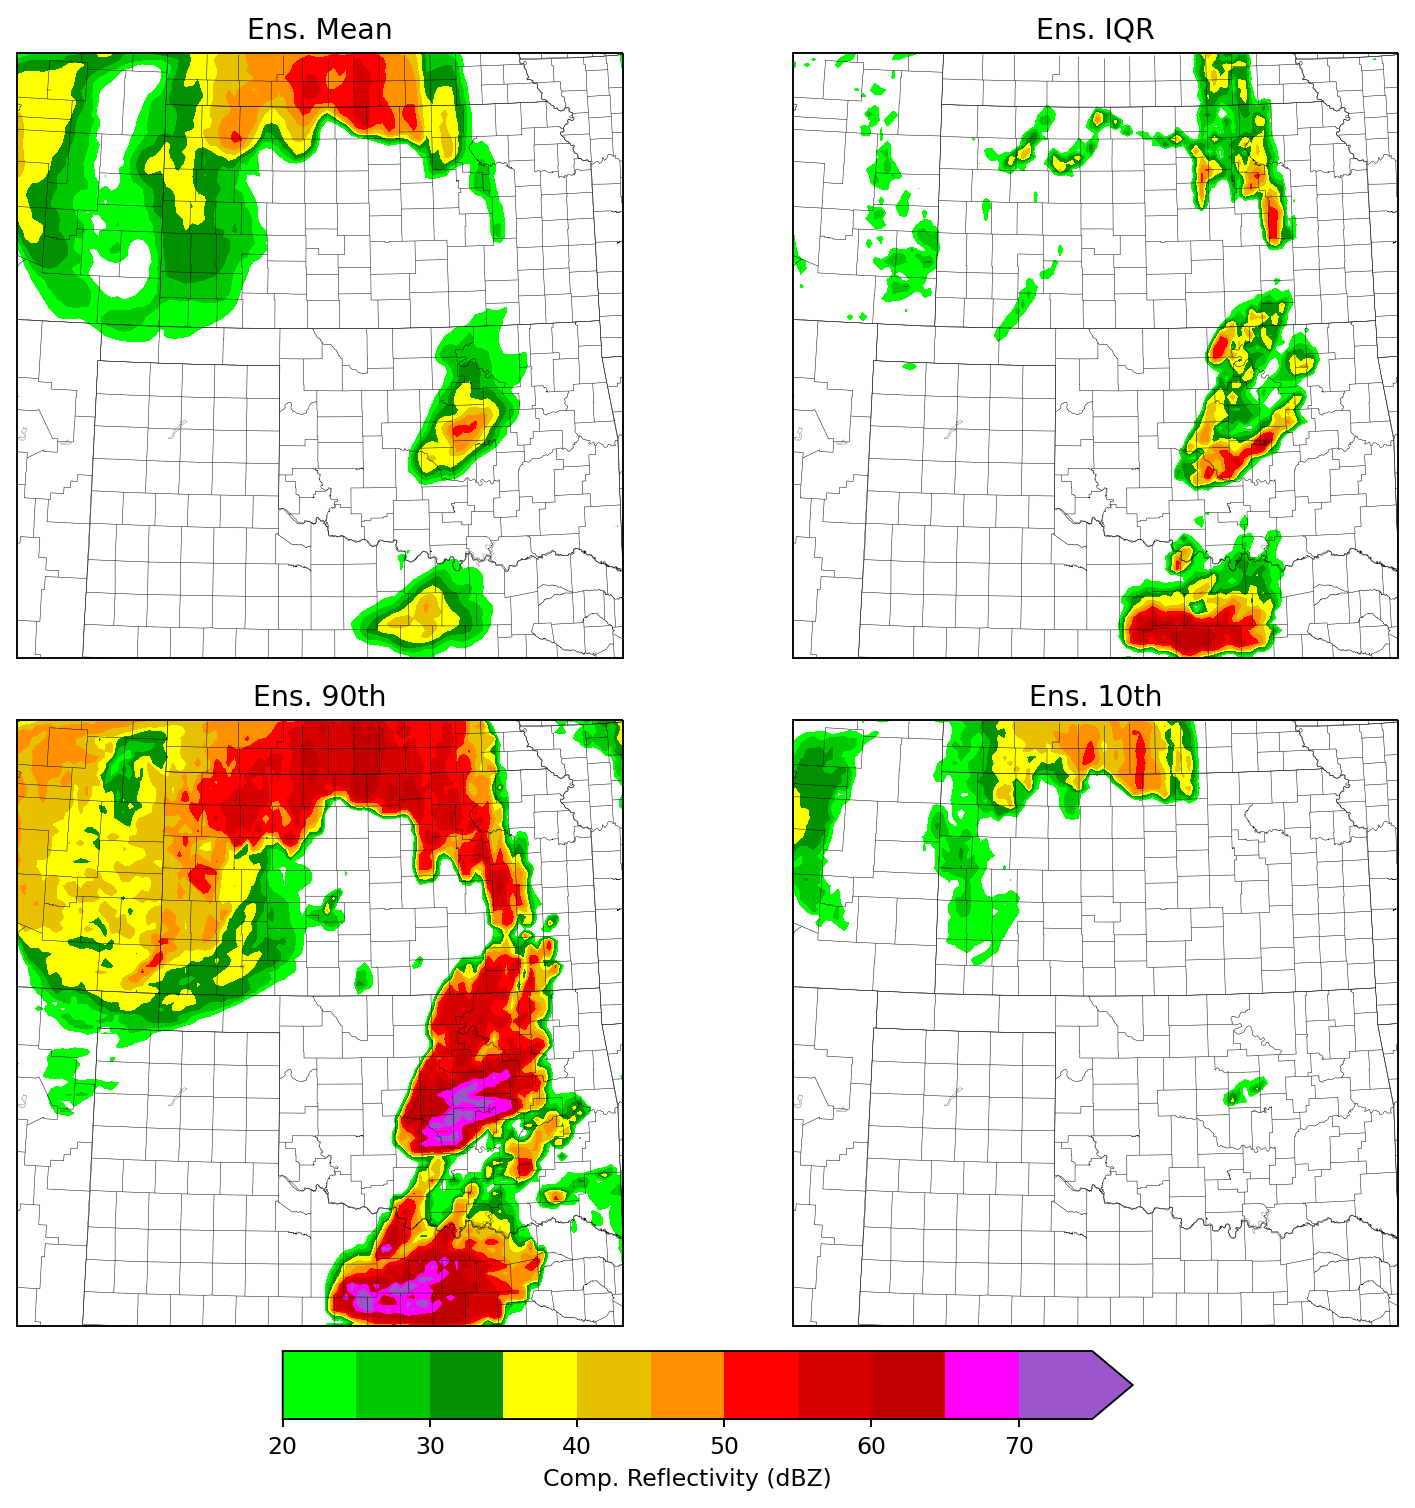

In [53]:
fig, axes = plt.subplots(figsize=(10,8), facecolor='w',
                     dpi=170, nrows=2, ncols=2, subplot_kw={'projection': projection}, 
                        constrained_layout=True)

levels= [dz_levels, dz_levels, dz_levels, dz_levels]
cmaps=[WoFSColors.nws_dz_cmap, WoFSColors.nws_dz_cmap, WoFSColors.nws_dz_cmap, WoFSColors.nws_dz_cmap]
labels=['Comp. Reflectivity (dBZ)', 'Comp. Reflectivity (dBZ)','Comp. Reflectivity (dBZ)','Comp. Reflectivity (dBZ)' ]
title='Comp. Reflectivity Ens. Mean & IQR on 9-km Grid'
X_s=[X_strm_stats['comp_dz__time_max__ens_mean'],X_strm_stats['comp_dz__time_max__ens_IQR'],X_strm_stats['comp_dz__time_max__ens_90th'], X_strm_stats['comp_dz__time_max__ens_10th']]

conts=[]
for ax, X, name, grid, cmap, level in zip(axes.flat,X_s,labels,[target_grid, target_grid, target_grid, target_grid], cmaps, levels):
    add_map_stuff(ax, states, shape_feature)

    cf = ax.contourf(grid[1],grid[0], X, transform = crs, cmap=cmap, levels=level, extend='max')
    conts.append(cf)
    
    ax = set_extent(ax, projection , crs, grid[0], grid[1],)
    
    fontsize = 10 if len(name) > 5 else 12



cax = fig.add_axes([0.25, -0.05, 0.5, 0.05])        
fig.colorbar(cont, cax=cax,label=label, orientation='horizontal', extend='max')

for ax, l in zip(axes.flat, ['Ens. Mean', 'Ens. IQR', 'Ens. 90th', 'Ens. 10th']):
    ax.set_title(l)

fig.tight_layout()
plt.show()

# Patch Extraction

In [54]:
ex.check_patches(True)


Requested patches are compatible with domain

Verbose Readout
------------
Patch (Shape, Area): ((16, 16), (256, 3840))
Forecast (Shape, Area): ((100, 100), 10000)
Number of Unused Gridpoints: 6160
Percent of Domain Used (%): 38.4

Maximum Number of patches (Area): 39.0
Maximum Number of patches (Grid): 36.0
Number of Unused Gridpoints if Max Patches: 16

Boundaryless Domain (N=True) (Shape, Area): ((98, 98), 9604)
Max Patches in Boundaryless Domain: 37.0
No. of Unused Gridpoints if Max Patches in Boundaryless Domain: 9049
------------


In [55]:
out = ex.extract_patches([X_strm_upscaled])[0] #Generally returns strm, env


Requested patches are compatible with domain

Verbose Readout
------------
Patch (Shape, Area): ((16, 16), (256, 3840))
Forecast (Shape, Area): ((100, 100), 10000)
Number of Unused Gridpoints: 6160
Percent of Domain Used (%): 38.4

Maximum Number of patches (Area): 39.0
Maximum Number of patches (Grid): 36.0
Number of Unused Gridpoints if Max Patches: 16

Boundaryless Domain (N=1) (Shape, Area): ((98, 98), 9604)
Max Patches in Boundaryless Domain: 37.0
No. of Unused Gridpoints if Max Patches in Boundaryless Domain: 9049
------------
[35 13 26 30 16 31 21 12  8 17  9 34  0  4 29]
[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]
 [24 25 26 27 28 29]
 [30 31 32 33 34 35]]
[(90, 90), (42, 26), (74, 42), (90, 10), (42, 74), (90, 26), (58, 58), (42, 10), (26, 42), (42, 90), (26, 58), (90, 74), (10, 10), (10, 74), (74, 90)]
[(90, 90), (42, 26), (74, 42), (90, 10), (42, 74), (90, 26), (58, 58), (42, 10), (26, 42), (42, 90), (26, 58), (90, 74), (10, 10), (10,

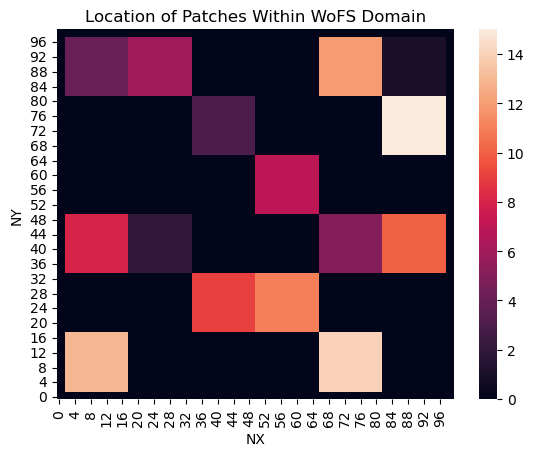

In [56]:
import seaborn as sns
fig, ax = plt.subplots()
sns.heatmap(ex._patch_grid)
ax.invert_yaxis()
ax.set_xlabel('NX')
ax.set_ylabel('NY')
ax.set_title('Location of Patches Within WoFS Domain')
plt.show()

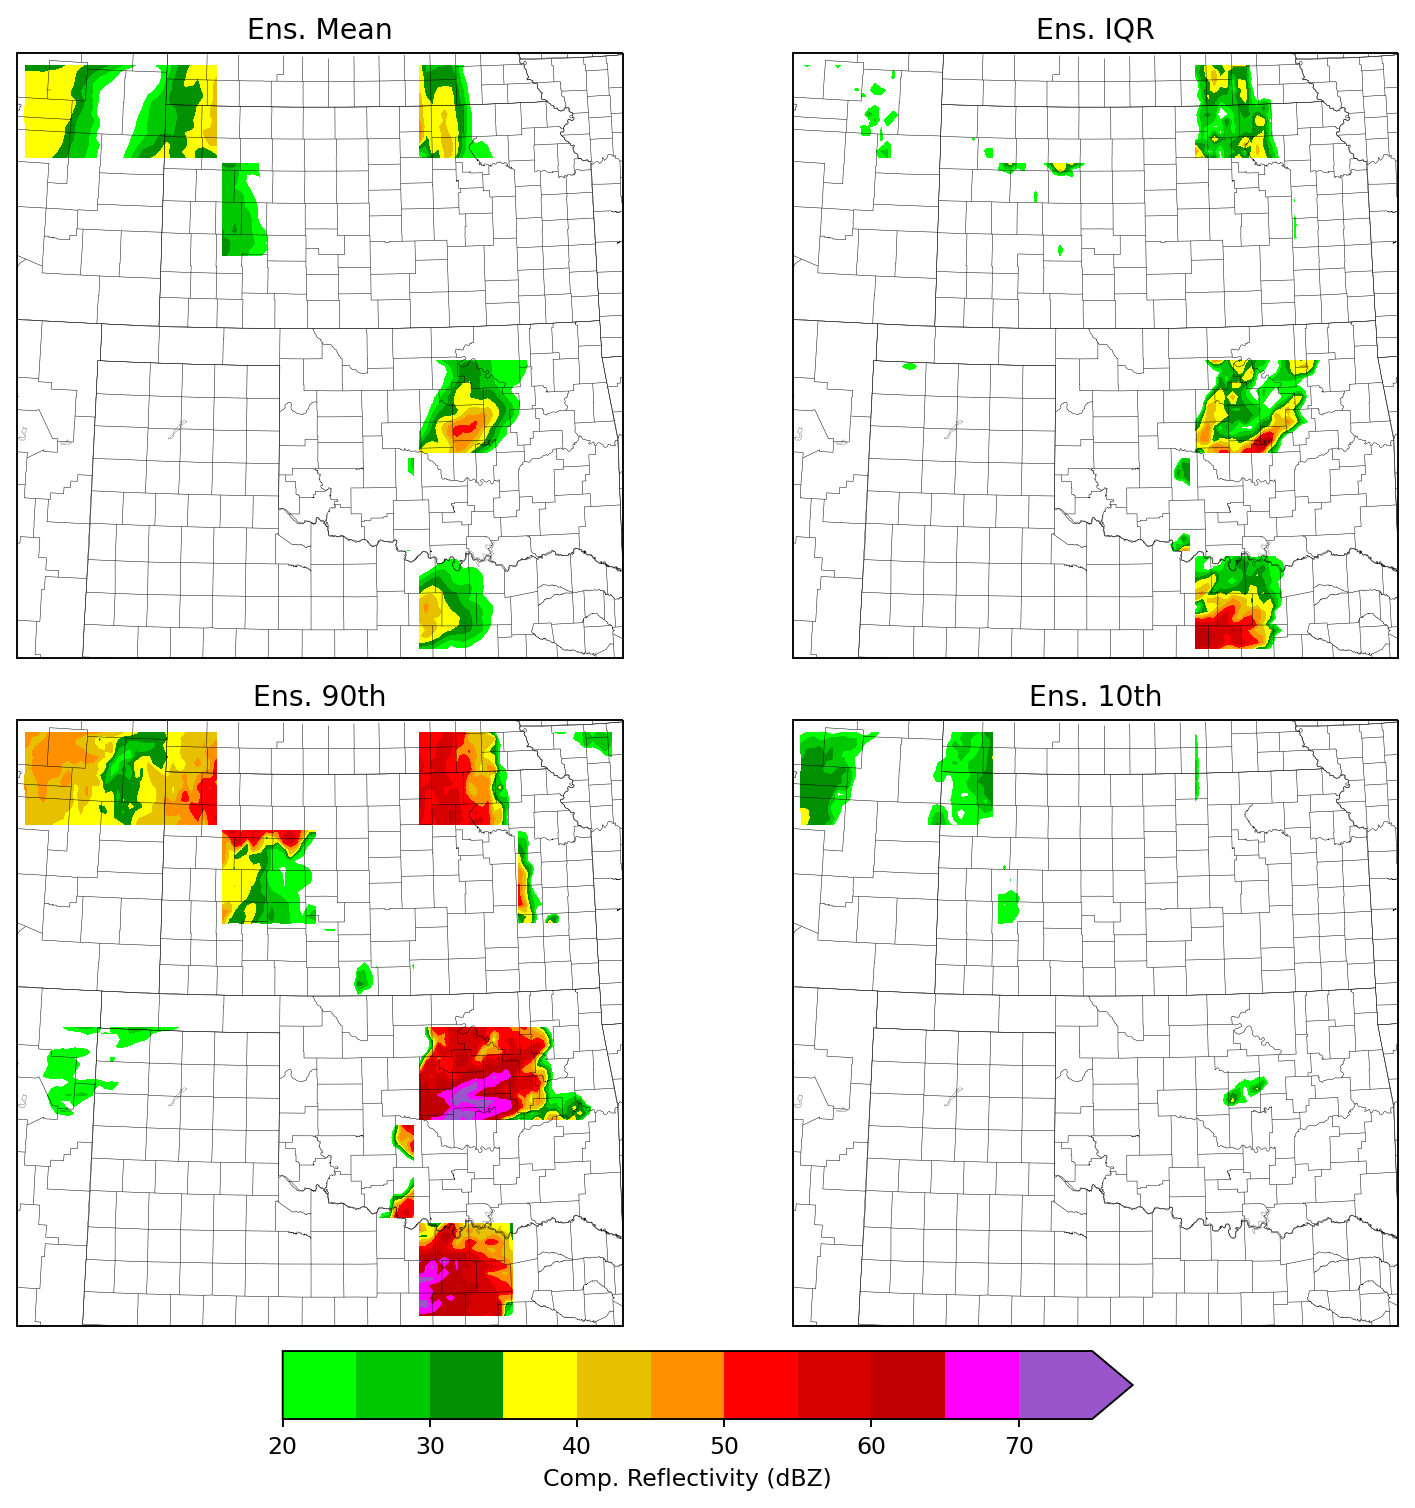

In [57]:
fig, axes = plt.subplots(figsize=(10,8), facecolor='w',
                     dpi=170, nrows=2, ncols=2, subplot_kw={'projection': projection}, 
                        constrained_layout=True)

levels= [dz_levels, dz_levels, dz_levels, dz_levels]
cmaps=[WoFSColors.nws_dz_cmap, WoFSColors.nws_dz_cmap, WoFSColors.nws_dz_cmap, WoFSColors.nws_dz_cmap]
labels=['Comp. Reflectivity (dBZ)', 'Comp. Reflectivity (dBZ)','Comp. Reflectivity (dBZ)','Comp. Reflectivity (dBZ)' ]
title='Comp. Reflectivity Ens. Mean & IQR on 9-km Grid'
X_s=[X_strm_stats['comp_dz__time_max__ens_mean'],X_strm_stats['comp_dz__time_max__ens_IQR'],X_strm_stats['comp_dz__time_max__ens_90th'],X_strm_stats['comp_dz__time_max__ens_10th']]

conts=[]
for ax, X, name, grid, cmap, level in zip(axes.flat,X_s,labels,[target_grid, target_grid, target_grid, target_grid], cmaps, levels):
    add_map_stuff(ax, states, shape_feature)

    #cf = ax.contourf(grid[1],grid[0], np.ma.masked_where(ex._patch_grid[::-1, :]==0, np.ones_like(X)*20), transform = crs, cmap=cmap, levels=level, extend='max')

####
    cf = ax.contourf(grid[1],grid[0], np.ma.masked_where(ex._patch_grid==0, X), transform = crs, cmap=cmap, levels=level, extend='max')
    conts.append(cf)
    
    ax = set_extent(ax, projection , crs, grid[0], grid[1],)
    
    fontsize = 10 if len(name) > 5 else 12



cax = fig.add_axes([0.25, -0.05, 0.5, 0.05])        
fig.colorbar(cont, cax=cax,label=label, orientation='horizontal', extend='max')

for ax, l in zip(axes.flat, ['Ens. Mean', 'Ens. IQR', 'Ens. 90th', 'Ens. 10th']):
    ax.set_title(l)
    
fig.tight_layout()
plt.show()

In [58]:
X_patch_time_comp=ex.calc_time_composite(out, func=np.nanmax, name='time_max', keys=ex._strm_vars, ax=1)
X_patch_stats=ex.calc_ensemble_stats(X_patch_time_comp, environ=False, ax=1)

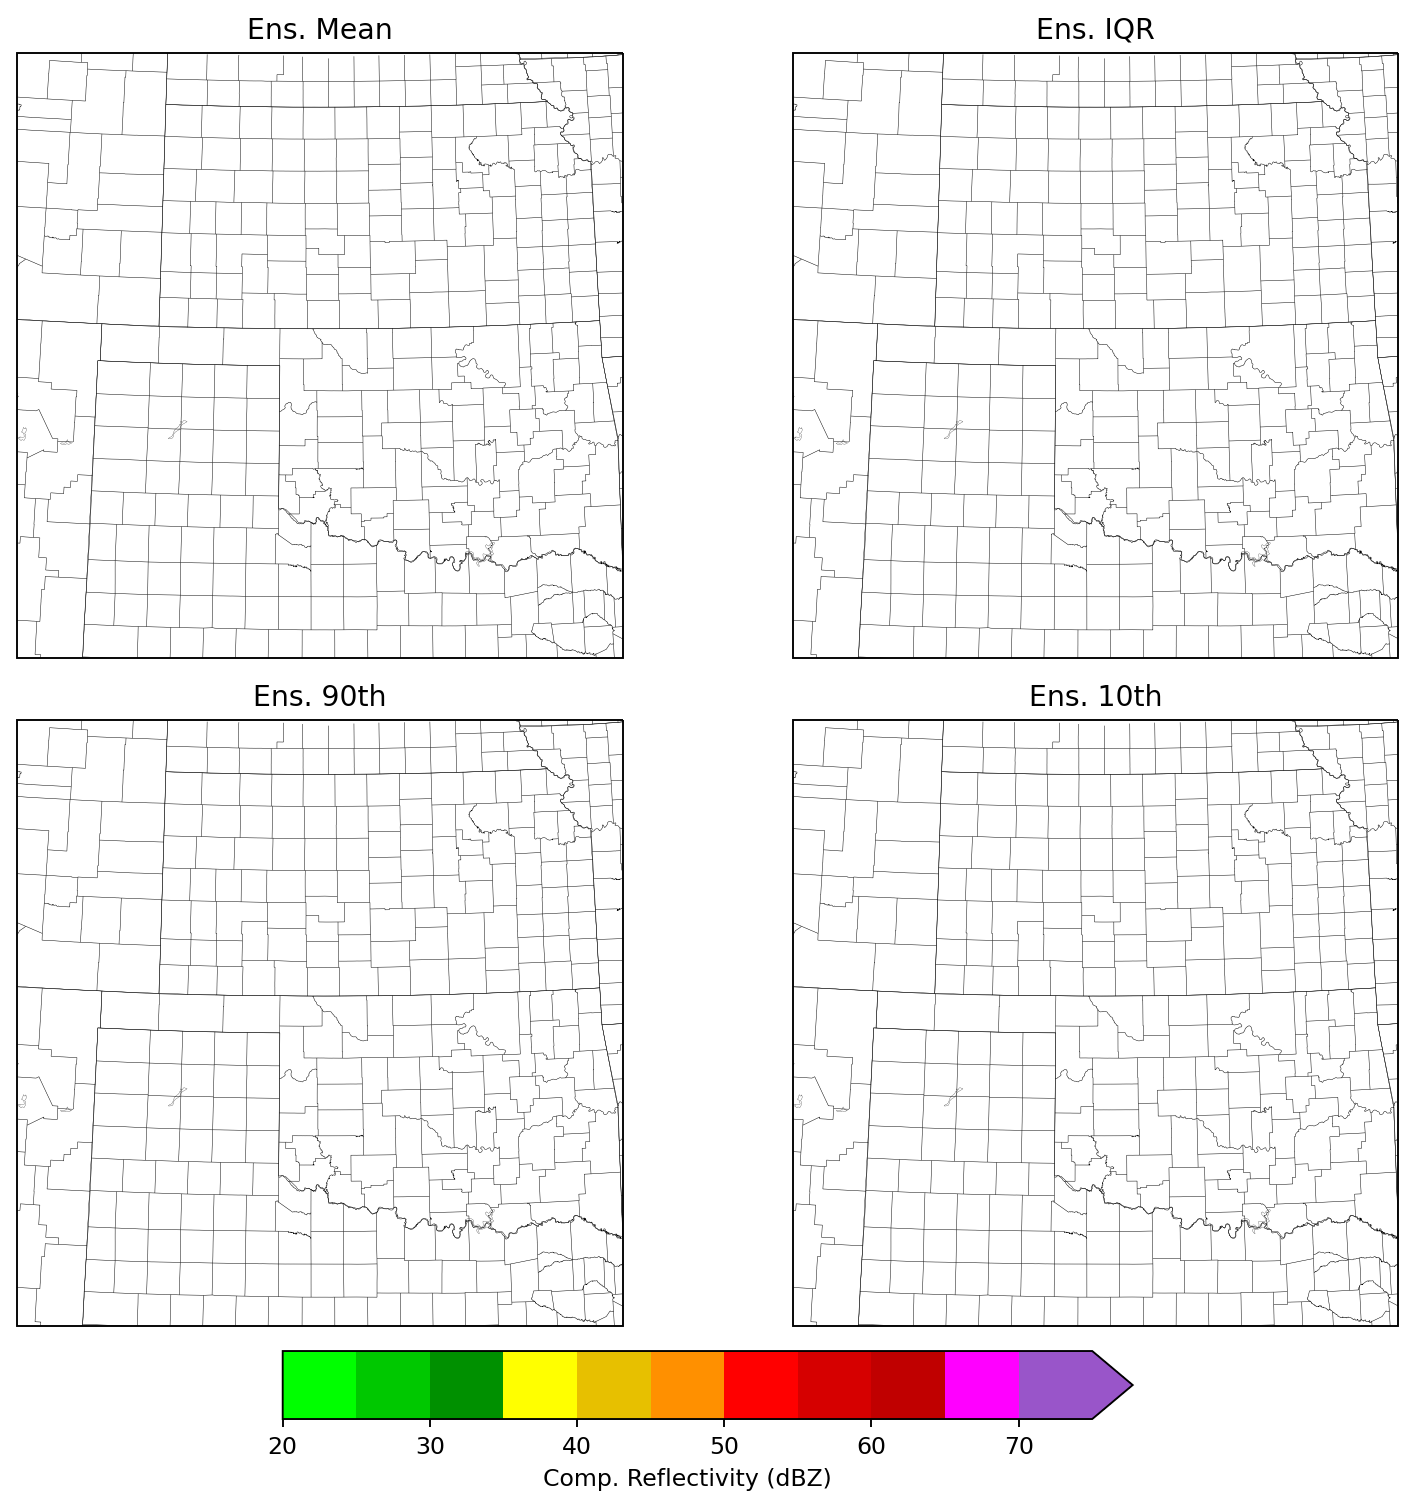

In [59]:
fig, axes = plt.subplots(figsize=(10,8), facecolor='w',
                     dpi=170, nrows=2, ncols=2, subplot_kw={'projection': projection}, 
                        constrained_layout=True)

levels= [dz_levels, dz_levels, dz_levels, dz_levels]
cmaps=[WoFSColors.nws_dz_cmap, WoFSColors.nws_dz_cmap, WoFSColors.nws_dz_cmap, WoFSColors.nws_dz_cmap]
labels=['Comp. Reflectivity (dBZ)', 'Comp. Reflectivity (dBZ)','Comp. Reflectivity (dBZ)','Comp. Reflectivity (dBZ)' ]
title='Comp. Reflectivity Ens. Mean & IQR on 9-km Grid'
patch_no=9
X_s=[X_patch_stats['comp_dz__time_max__ens_mean'][patch_no-1],X_patch_stats['comp_dz__time_max__ens_IQR'][patch_no-1],X_patch_stats['comp_dz__time_max__ens_90th'][patch_no-1], X_patch_stats['comp_dz__time_max__ens_10th'][patch_no-1]]

conts=[]
for ax, X, name, grid, cmap, level in zip(axes.flat,X_s,labels,[target_grid, target_grid, target_grid, target_grid], cmaps, levels):
    add_map_stuff(ax, states, shape_feature)
    
    lat_bounds = (np.nanmin(np.argwhere(ex._patch_grid==patch_no)[:,0]), np.nanmax(np.argwhere(ex._patch_grid==patch_no)[:,0]))
    lon_bounds = (np.nanmin(np.argwhere(ex._patch_grid==patch_no)[:,1]), np.nanmax(np.argwhere(ex._patch_grid==patch_no)[:,1]))
    sub_grid_y=grid[0][lat_bounds[0]:lat_bounds[-1]+1, lon_bounds[0]:lon_bounds[-1]+1]
    sub_grid_x=grid[1][lat_bounds[0]:lat_bounds[-1]+1, lon_bounds[0]:lon_bounds[-1]+1]
    
    
    cf = ax.contourf(sub_grid_x, sub_grid_y, X, transform = crs, cmap=cmap, levels=level, extend='max')
    conts.append(cf)
    
    ax = set_extent(ax, projection , crs, grid[0], grid[1],)
    
    fontsize = 10 if len(name) > 5 else 12



cax = fig.add_axes([0.25, -0.05, 0.5, 0.05])        
fig.colorbar(cont, cax=cax,label=label, orientation='horizontal', extend='max')

for ax, l in zip(axes.flat, ['Ens. Mean', 'Ens. IQR', 'Ens. 90th', 'Ens. 10th']):
    ax.set_title(l)
    
fig.tight_layout()
plt.show()

In [60]:
np.shape(X_patch_stats['comp_dz__time_max__ens_mean'])
#Ultimately want shape (patches, Y, X, features)

(15, 16, 16)

# Getting the Targets

In [61]:
#mesh = MeshGrabber(ex._ncfile, ex._upscale_size)
#m = mesh.load()
ex._ncfile

'/work/mflora/SummaryFiles/20230511_d1/0000/wofs_ALL_24_20230512_0000_0200.nc'

In [62]:
"""try:
    xr.concat([xr.load_dataset(f, drop_variables=['lat','lon'])['mesh_consv'] for f in mesh_files], dim='time')
except:
    print('Default MESH Read-in failed, trying alternate method')
    temp=[xr.load_dataset(f, drop_variables=['lat','lon'])['mesh_consv'].values for f in mesh_files]
    temp=np.max(temp, axis=0)
    print(temp)"""

"try:\n    xr.concat([xr.load_dataset(f, drop_variables=['lat','lon'])['mesh_consv'] for f in mesh_files], dim='time')\nexcept:\n    print('Default MESH Read-in failed, trying alternate method')\n    temp=[xr.load_dataset(f, drop_variables=['lat','lon'])['mesh_consv'].values for f in mesh_files]\n    temp=np.max(temp, axis=0)\n    print(temp)"

In [63]:
#len(MeshGrabber(ex._ncfile, ex._upscale_size).find_mrms_files())

In [64]:
#len(mesh_files[:-7])

In [65]:
mesh = MeshGrabber(ex._ncfile, ex._upscale_size)
mesh_files = mesh.find_mrms_files()
for f in mesh_files:
    print(str(f))
    xr.load_dataset(f, drop_variables=['lat','lon'])

/work/rt_obs/MRMS/RAD_AZS_MSH/2023/20230511_d1/wofs_MRMS_RAD_20230512_0145.nc
/work/rt_obs/MRMS/RAD_AZS_MSH/2023/20230511_d1/wofs_MRMS_RAD_20230512_0150.nc
/work/rt_obs/MRMS/RAD_AZS_MSH/2023/20230511_d1/wofs_MRMS_RAD_20230512_0155.nc
/work/rt_obs/MRMS/RAD_AZS_MSH/2023/20230511_d1/wofs_MRMS_RAD_20230512_0200.nc
/work/rt_obs/MRMS/RAD_AZS_MSH/2023/20230511_d1/wofs_MRMS_RAD_20230512_0205.nc
/work/rt_obs/MRMS/RAD_AZS_MSH/2023/20230511_d1/wofs_MRMS_RAD_20230512_0210.nc
/work/rt_obs/MRMS/RAD_AZS_MSH/2023/20230511_d1/wofs_MRMS_RAD_20230512_0215.nc
/work/rt_obs/MRMS/RAD_AZS_MSH/2023/20230511_d1/wofs_MRMS_RAD_20230512_0220.nc
/work/rt_obs/MRMS/RAD_AZS_MSH/2023/20230511_d1/wofs_MRMS_RAD_20230512_0225.nc
/work/rt_obs/MRMS/RAD_AZS_MSH/2023/20230511_d1/wofs_MRMS_RAD_20230512_0230.nc
/work/rt_obs/MRMS/RAD_AZS_MSH/2023/20230511_d1/wofs_MRMS_RAD_20230512_0235.nc
/work/rt_obs/MRMS/RAD_AZS_MSH/2023/20230511_d1/wofs_MRMS_RAD_20230512_0240.nc
/work/rt_obs/MRMS/RAD_AZS_MSH/2023/20230511_d1/wofs_MRMS_RAD_202

In [66]:
y = ex.get_targets(ex._forecast_window)
print(y.keys())

dict_keys(['tornado_severe__36km', 'hail_severe__36km', 'wind_severe__36km', 'tornado_sig_severe__36km', 'hail_sig_severe__36km', 'wind_sig_severe__36km', 'MESH_severe__36km', 'tornado_severe__18km', 'hail_severe__18km', 'wind_severe__18km', 'tornado_sig_severe__18km', 'hail_sig_severe__18km', 'wind_sig_severe__18km', 'MESH_severe__18km', 'tornado_severe__4km', 'hail_severe__4km', 'wind_severe__4km', 'tornado_sig_severe__4km', 'hail_sig_severe__4km', 'wind_sig_severe__4km', 'MESH_severe__4km', 'any_severe__4km', 'any_severe__18km', 'any_severe__36km', 'any_sig_severe__4km', 'any_sig_severe__18km', 'any_sig_severe__36km'])


In [67]:
for l in y.keys():
    print(np.mean(y[l]))

0.0109375
0.019270833333333334
0.0020833333333333333
0.0
0.0
0.0
0.003125
0.00234375
0.0020833333333333333
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0036458333333333334
0.023177083333333334
0.0
0.0
0.0


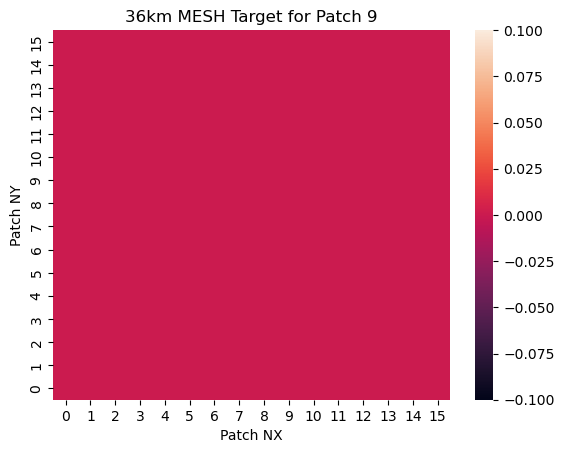

In [68]:
fig, ax =plt.subplots()
sns.heatmap(y['MESH_severe__36km'][patch_no-1])
ax.invert_yaxis()
ax.set_ylabel('Patch NY')
ax.set_xlabel('Patch NX')
ax.set_title(f'36km MESH Target for Patch {patch_no}')
plt.show()

In [69]:
mesh = MeshGrabber(ncfile, ex._upscale_size)()#Return boolean, Upscale size
mesh=mesh[::ex._upscale_size, ::ex._upscale_size]
mesh = maximum_filter(mesh, ex._TARGET_SIZES[-1])

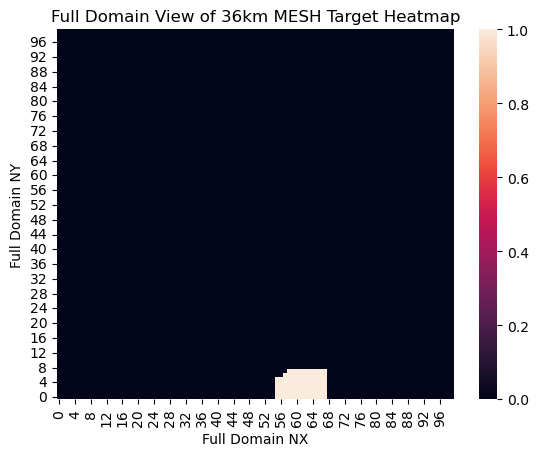

In [70]:
fig, ax = plt.subplots()
sns.heatmap(mesh)
ax.invert_yaxis()
ax.set_xlabel('Full Domain NX')
ax.set_ylabel('Full Domain NY')
ax.set_title('Full Domain View of 36km MESH Target Heatmap')
plt.show()

In [71]:
print(X_patch_stats.keys())

dict_keys(['uh_2to5_instant__time_max__ens_mean', 'uh_0to2_instant__time_max__ens_mean', 'wz_0to2_instant__time_max__ens_mean', 'comp_dz__time_max__ens_mean', 'ws_80__time_max__ens_mean', 'hailcast__time_max__ens_mean', 'w_up__time_max__ens_mean', 'okubo_weiss__time_max__ens_mean', 'ctt__time_max__ens_mean', 'uh_2to5_instant__time_max__ens_90th', 'uh_0to2_instant__time_max__ens_90th', 'wz_0to2_instant__time_max__ens_90th', 'comp_dz__time_max__ens_90th', 'ws_80__time_max__ens_90th', 'hailcast__time_max__ens_90th', 'w_up__time_max__ens_90th', 'okubo_weiss__time_max__ens_90th', 'ctt__time_max__ens_90th', 'uh_2to5_instant__time_max__ens_10th', 'uh_0to2_instant__time_max__ens_10th', 'wz_0to2_instant__time_max__ens_10th', 'comp_dz__time_max__ens_10th', 'ws_80__time_max__ens_10th', 'hailcast__time_max__ens_10th', 'w_up__time_max__ens_10th', 'okubo_weiss__time_max__ens_10th', 'ctt__time_max__ens_10th', 'uh_2to5_instant__time_max__ens_IQR', 'uh_0to2_instant__time_max__ens_IQR', 'wz_0to2_instant

# Creating Metadata

In [72]:
comps=decompose_file_path(ex._ncfile)
metadata={'run_date':[comps['VALID_DATE'] for i in range(ex._n_patches)]}
metadata['init_time']=[comps['INIT_TIME'] for i in range(ex._n_patches)]
metadata['patch_no']=[i+1 for i in range(ex._n_patches)]
metadata['NY']=(['patch','NY_Lat'],[np.argwhere(ex._patch_grid==i+1)[:,0] for i in range(ex._n_patches)])
metadata['NX']=(['patch','NX_Lon'], [np.argwhere(ex._patch_grid==i+1)[:,1] for i in range(ex._n_patches)])
metadata_ds = xr.Dataset(metadata)
metadata_ds

<xarray.Dataset>
Dimensions:    (run_date: 15, init_time: 15, patch_no: 15, patch: 15,
                NY_Lat: 256, NX_Lon: 256)
Coordinates:
  * run_date   (run_date) <U8 '20230512' '20230512' ... '20230512' '20230512'
  * init_time  (init_time) <U4 '0000' '0000' '0000' ... '0000' '0000' '0000'
  * patch_no   (patch_no) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
Dimensions without coordinates: patch, NY_Lat, NX_Lon
Data variables:
    NY         (patch, NY_Lat) int64 82 82 82 82 82 82 82 ... 81 81 81 81 81 81
    NX         (patch, NX_Lon) int64 82 83 84 85 86 87 88 ... 92 93 94 95 96 97

# Preparing to Save the Data

We convert the data into an xarray dataset, which is returned by the make_dataset() method. The file is saved and closed in the parent script.

In [73]:
#Turn Data into xarray dataset to save as NCDF
data={**X_patch_stats, **y}
data = {v : (['patch_no','NY','NX'], data[v]) for v in data.keys()}
ds = xr.Dataset(data)
ds

<xarray.Dataset>
Dimensions:                              (patch_no: 15, NY: 16, NX: 16)
Dimensions without coordinates: patch_no, NY, NX
Data variables: (12/63)
    uh_2to5_instant__time_max__ens_mean  (patch_no, NY, NX) float64 0.1277 .....
    uh_0to2_instant__time_max__ens_mean  (patch_no, NY, NX) float64 0.03697 ....
    wz_0to2_instant__time_max__ens_mean  (patch_no, NY, NX) float64 0.0001451...
    comp_dz__time_max__ens_mean          (patch_no, NY, NX) float64 2.238 ......
    ws_80__time_max__ens_mean            (patch_no, NY, NX) float64 19.81 ......
    hailcast__time_max__ens_mean         (patch_no, NY, NX) float64 0.0 ... 0.0
    ...                                   ...
    any_severe__4km                      (patch_no, NY, NX) int64 0 0 0 ... 0 0
    any_severe__18km                     (patch_no, NY, NX) int64 0 0 0 ... 0 0
    any_severe__36km                     (patch_no, NY, NX) int64 0 0 0 ... 0 0
    any_sig_severe__4km                  (patch_no, NY, NX) int64 0 0 0 ... 0 0
    any_sig_severe__18km                 (patch_no, NY, NX) int64 0 0 0 ... 0 0
    any_sig_severe__36km                 (patch_no, NY, NX) int64 0 0 0 ... 0 0

# Usage

All of the methods above are included within the make_dataset method of the PatchExtractor class, allowing us to condense the code as follows:

In [74]:
#xr.load_dataset(MeshGrabber(ncfile,3).find_mrms_files()[0])

In [ ]:
ex=PatchExtractor(ncfile, ll_grid, X_env.keys(), X_strm.keys(), 10, (16,16), verbose=True)
d1, meta = ex.make_dataset(X_env=X_env, X_strm=X_strm)

#Within parent script:
#ds.to_netcdf(path)
#ds.close()
#metadata.to_netcdf(path2)
#metadata.close()

In [ ]:
np.all(d1['uh_2to5_instant__time_max__ens_mean'][0].values == X_patch_stats['uh_2to5_instant__time_max__ens_mean'][0])